##### Ana Kurulum

In [1]:
!pip install findspark

In [2]:
import findspark
findspark.init("/Users/alperencngzz/Documents/spark/spark-3.3.0-bin-hadoop3")

Buraya kadar yaptığmız Spark ve python'u birlikte çalıştırabilmek için yaptığımız path ayarları oluyor. Fiziksel bir yol gösterme gibi

## Configurasyon ve Spark Bağlantısı

Buradakiler ise bir spark uygulaması çalıştırmak (session başlatmak) ve sessionla ilgili configurasyonlar yapıp bağlantısını sağlayıp temel işlemleri yapma durumuna gelmiş olacağız. Öncelikle ilkel bir spark bağlantısı oluşturalım:

In [3]:
from pyspark import SparkContext
sc = SparkContext(master = "local")
sc

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/26 09:12:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/09/26 09:12:46 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


<SparkContext master=local appName=pyspark-shell>

In [4]:
sc.version

'3.3.0'

In [5]:
sc.sparkUser()

'alperencngzz'

In [6]:
sc.appName

'pyspark-shell'

In [7]:
sc.stop()

In [8]:
# şimdi düzgünce ayarlamalara geçiyoruz

In [9]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext

spark = SparkSession.builder \
    .master("local") \
    .appName("pyspark_uygulama") \
    .config("spark.executer.memory", "16gb") \
    .getOrCreate()



sc = spark.sparkContext
sc

22/09/26 09:12:47 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


<SparkContext master=local appName=pyspark_uygulama>

Şuan uygulamamızı oluşturduk ve çalışır hale getirdik, şimdi temel dataframe işlemlerini yapacağız

## Temel DataFrame İşlemleri (beggining)

Eskidan pd dataframe'miz vardı, bundan sonra spark df söz konusu olacak.

Pandasda alışık olduğumuz her fonksiyon spark için kullanılamaz. Python ancak aradaki protokole göre belirlenen veya dönüştürülen fonks. kullanabilir.

In [10]:
# spark df oluşturma

In [11]:
spark_df = spark.read.csv("diabetes.csv", header = True, inferSchema = True)

In [12]:
spark_df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



In [13]:
type(spark_df)

pyspark.sql.dataframe.DataFrame

In [14]:
# şimdi veriyi cache'leme (hızlı kullanım için ram'e taşıma) işlemi yapacağız

In [15]:
spark_df.cache()

DataFrame[Pregnancies: int, Glucose: int, BloodPressure: int, SkinThickness: int, Insulin: int, BMI: double, DiabetesPedigreeFunction: double, Age: int, Outcome: int]

In [16]:
type(spark_df)

pyspark.sql.dataframe.DataFrame

Yukarıdaki işlemlerle verimizi spark'da yapacağımız çeşitli işlemler için işlenebilir hale getirme işlemini gerçekleştirdik.

In [17]:
import seaborn as sns
df = sns.load_dataset("diamonds")
df = df.select_dtypes(include = ["float64", "int64"])

In [18]:
type(df)

pandas.core.frame.DataFrame

In [19]:
# şimdi birkaç işlem karşılaştırması yapalım

In [20]:
df.head()

,carat,depth,table,price,x,y,z
0,0.23,61.5,55.0,326,3.95,3.98,2.43
1,0.21,59.8,61.0,326,3.89,3.84,2.31
2,0.23,56.9,65.0,327,4.05,4.07,2.31
3,0.29,62.4,58.0,334,4.20,4.23,2.63
4,0.31,63.3,58.0,335,4.34,4.35,2.75


In [21]:
spark_df.head()

Row(Pregnancies=6, Glucose=148, BloodPressure=72, SkinThickness=35, Insulin=0, BMI=33.6, DiabetesPedigreeFunction=0.627, Age=50, Outcome=1)

In [22]:
df.dtypes

carat    float64
depth    float64
table    float64
price      int64
x        float64
y        float64
z        float64
dtype: object

In [23]:
spark_df.dtypes

[('Pregnancies', 'int'),
 ('Glucose', 'int'),
 ('BloodPressure', 'int'),
 ('SkinThickness', 'int'),
 ('Insulin', 'int'),
 ('BMI', 'double'),
 ('DiabetesPedigreeFunction', 'double'),
 ('Age', 'int'),
 ('Outcome', 'int')]

In [24]:
df.ndim

2

In [25]:
spark_df.ndim

AttributeError: 'DataFrame' object has no attribute 'ndim'

burada gördüğümüz gibi ortak olan veya olmayan fonksiyonlar olabilir.

## Temel DataFrame İşlemleri

Temel farklar:
1. Pandas df'i paralel çalışmaz, spark df'i farklı noktalarda cluster içinde paralel çalışabilir
2. Spark df'i lazy'dir
3. Spark df'i immutable'dır, değiştirmek yerine dönüştürme işlemleri yapıyoruz
4. Pandas'ın veri manipulasyonları çok zengindir, spark'da kısıtlıdır. 

Temel anlamda pd kullanarak spark üzerinde veri manipülasyonu gerçekleştiriyor olacağız.

In [26]:
spark_df.head()

Row(Pregnancies=6, Glucose=148, BloodPressure=72, SkinThickness=35, Insulin=0, BMI=33.6, DiabetesPedigreeFunction=0.627, Age=50, Outcome=1)

In [32]:
spark_df.show(5, truncate = True)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



In [33]:
spark_df.count()

768

In [37]:
spark_df.columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

In [39]:
spark_df.describe().show()

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|summary|       Pregnancies|          Glucose|     BloodPressure|     SkinThickness|           Insulin|               BMI|DiabetesPedigreeFunction|               Age|           Outcome|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|  count|               768|              768|               768|               768|               768|               768|                     768|               768|               768|
|   mean|3.8450520833333335|     120.89453125|       69.10546875|20.536458333333332| 79.79947916666667|31.992578124999977|      0.4718763020833327|33.240885416666664|0.3489583333333333|
| stddev|  3.36957806269887|31.97261819513622|19.355807170644777|15.95

### Değişken Seçme İşlemleri

In [40]:
spark_df.describe("Glucose").show()

+-------+-----------------+
|summary|          Glucose|
+-------+-----------------+
|  count|              768|
|   mean|     120.89453125|
| stddev|31.97261819513622|
|    min|                0|
|    max|              199|
+-------+-----------------+



In [41]:
spark_df.describe("Glucose")

DataFrame[summary: string, Glucose: string]

Spark'ın "Lazy" özelliklerinden birisi yukarıdaki örnekte görünüyor. Show koymadığımızda bize yapıyı gösterirken görsel şekilde görmek için .show

In [42]:
spark_df.select("Glucose", "Insulin").show(5)

+-------+-------+
|Glucose|Insulin|
+-------+-------+
|    148|      0|
|     85|      0|
|    183|      0|
|     89|     94|
|    137|    168|
+-------+-------+
only showing top 5 rows



In [47]:
# eşsiz gözlemlerin seçimi
spark_df.select("Pregnancies").distinct().show()

+-----------+
|Pregnancies|
+-----------+
|         12|
|          1|
|         13|
|          6|
|          3|
|          5|
|         15|
|          9|
|         17|
|          4|
|          8|
|          7|
|         10|
|         11|
|         14|
|          2|
|          0|
+-----------+



In [48]:
spark_df.select("Pregnancies").distinct().count()

17

In [49]:
# tekrarlayan gözlemleri silme

In [50]:
spark_df.select("Glucose").dropDuplicates().show()

+-------+
|Glucose|
+-------+
|    148|
|     85|
|    137|
|     65|
|    133|
|     78|
|    155|
|    108|
|    193|
|    115|
|    126|
|    101|
|     81|
|    183|
|     76|
|    159|
|     44|
|    103|
|     91|
|    128|
+-------+
only showing top 20 rows



In [51]:
# Çaprazlayarak Tabloda Görme
spark_df.crosstab("Outcome", "Pregnancies").show()

+-------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|Outcome_Pregnancies|  0|  1| 10| 11| 12| 13| 14| 15| 17|  2|  3|  4|  5|  6|  7|  8|  9|
+-------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|                  1| 38| 29| 10|  7|  4|  5|  2|  1|  1| 19| 27| 23| 21| 16| 25| 22| 18|
|                  0| 73|106| 14|  4|  5|  5|  0|  0|  0| 84| 48| 45| 36| 34| 20| 16| 10|
+-------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+



In [53]:
# aşağının çıktısı gözlem sayımızla aynı olduğundan eksik gözlem yok diyebiliriz
spark_df.dropna().count()

768

In [54]:
spark_df.dropna().show(3)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 3 rows



### Gözlem Seçme İşlemleri

In [56]:
spark_df.filter(spark_df.Age >40).count()

194

In [58]:
spark_df.groupby("Outcome").count().show()

+-------+-----+
|Outcome|count|
+-------+-----+
|      1|  268|
|      0|  500|
+-------+-----+



In [60]:
spark_df.groupby("Outcome").agg({"Age": "mean"}).show()

+-------+-----------------+
|Outcome|         avg(Age)|
+-------+-----------------+
|      1|37.06716417910448|
|      0|            31.19|
+-------+-----------------+



In [61]:
# değişken ekleme, silme

In [63]:
spark_df.withColumn("new_column", spark_df.BMI / 2).select("BMI", "new_column").show(5)

+----+----------+
| BMI|new_column|
+----+----------+
|33.6|      16.8|
|26.6|      13.3|
|23.3|     11.65|
|28.1|     14.05|
|43.1|     21.55|
+----+----------+
only showing top 5 rows



In [64]:
# .withColumn("new_column", column_data) -> yeni değişken eklemek için kullanılan fonksiyon

In [68]:
spark_df.withColumnRenamed("Outcome", "bagimli_degisken").columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'bagimli_degisken']

In [70]:
spark_df.show(3) # burada da gördüğmüz gibi ana yapı korunuyor, işlemler ram üzerinde saklanarak yapılıyor

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 3 rows



In [71]:
spark_df.drop("Insulin").columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

Python ve sparkı beraber kullanırken bazı verileri spark'dan python tarafına çekip localimizde kullanmak istediğimizde topandas isimli fonksiyonu kullanmamız gerekiyor. 

Verimizi catchlemiştik ve birtakım işlemler gerçekleştirmiştik. Bu çıktıları pythona çekmek istediğimizde:

In [74]:
spark_df.groupby("Outcome").count().toPandas() # spark df'inden pandas df'ine dönüşüm gerçekleşti

,Outcome,count
0,1,268
1,0,500


In [75]:
a = spark_df.groupby("Outcome").count().toPandas()

In [80]:
a.iloc[0:1, 1:2]

,count
0,268


Burada sparkın rolü elimizdeki verisetiyle çok iyi anlaşılmıyor ama büyük veri dünyasından bir veriyle uğraşıyor olsaydık pandas'a geçmeden önce belli indirgeme işlemlerini spark ile yapmamız gerekirdi mesela *agg* fonksiyonunun kullanımı gibi 

## SQL işlemleri

In [81]:
spark_df.registerTempTable("table_df")

/Users/alperencngzz/Documents/spark/spark-3.3.0-bin-hadoop3/python/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [82]:
spark.sql("show databases").show()

+---------+
|namespace|
+---------+
|  default|
+---------+



In [83]:
spark.sql("show tables").show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
|         | table_df|       true|
+---------+---------+-----------+



In [84]:
spark.sql("select Glucose from table_df").show(5)

+-------+
|Glucose|
+-------+
|    148|
|     85|
|    183|
|     89|
|    137|
+-------+
only showing top 5 rows



In [85]:
spark.sql("select Outcome, mean(Glucose) from table_df group by Outcome").show(5)

+-------+------------------+
|Outcome|     mean(Glucose)|
+-------+------------------+
|      1|141.25746268656715|
|      0|            109.98|
+-------+------------------+



## Büyük Veri Görselleştirme

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

In [88]:
sns.barplot(x = "Outcome", y = spark_df.Outcome.index, data = spark_df) # hata veriyor pd komutlarıyla denediğimizde

AttributeError: 'DataFrame' object has no attribute 'get'

Büyük veri görselleştirme 2 basamaktan oluşur:
1. Veriyi Hadoop (veya herhangi bir büyük veri depolama alanı) üzerinden spark'a çekiyoruz ve görselleştirmek istediğimiz şekilde veriyi indirgeyeceğiz (agg gibi komutlarla) 
2. İndirgeme işleminden sonra veriyi toPandas ile dönüştürüp localimize gelebilecek hale getireceğiz ve sonra veriyi görselleştirme işlemlerine sokabileceğiz

Yani spark tarafında aggregate etmek, görselleştirmek istenen şeylere dönüştürmek sonrasında veriyi pandasa çekip görselleştirmek.

In [89]:
sdf = spark_df.toPandas() # veri zaten localimizde ve küçük olduğundan işleme gerek duymadık
sdf.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


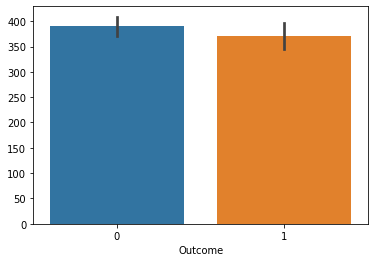

In [91]:
sns.barplot(x = "Outcome", y = sdf.Outcome.index, data = sdf);